In [1]:
%run 'librairies.ipynb'

In [2]:
import requests
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import squarify

In [3]:
def get_datasets(site_id):

    endpoint = 'https://stats.data.gouv.fr/'
    
    params = {
        'idSite': site_id,
        'module': 'API',
        'method': 'Actions.getPageUrls',
        'format': 'json',
        'depth': 4,
        'expanded': 1,
        'flat': 1,
        'period': 'range',
        'date': '2019-01-01,2019-12-31',
        'filter_pattern': '/fr/datasets/.+',
        'filter_limit': -1
    }
        
    r = requests.get(endpoint, params=params)
    
    # DEBUG
    print(r.url)
    # print(r.json())
    
    df = pd.DataFrame(r.json())
    
    # <CLEAN> Remove total of `fr/datasets/`
    df.sort_values(by=['nb_hits'], inplace=True, ascending=False)
    df = df.iloc[1:]
    
    return df

In [4]:
df = get_datasets(1)

https://stats.data.gouv.fr/?idSite=1&module=API&method=Actions.getPageUrls&format=json&depth=4&expanded=1&flat=1&period=range&date=2019-01-01%2C2019-12-31&filter_pattern=%2Ffr%2Fdatasets%2F.%2B&filter_limit=-1


In [5]:
df = df[ df['url'].apply(lambda x: not('oembed' in str(x)) ) ]

In [6]:
df['nb_hits'].median()

1.0

In [7]:
df['nb_hits']

2      267451
1      246129
3      145480
5      119269
4      118819
        ...  
674         1
675         1
676         1
677         1
672         1
Name: nb_hits, Length: 1102, dtype: int64

In [8]:
df['nb_hits'].quantile(np.linspace(.1, 1, 10, 1),interpolation='higher')

0.1         1
0.2         1
0.3         1
0.4         1
0.5         1
0.6         2
0.7         2
0.8         3
0.9        12
1.0    267451
Name: nb_hits, dtype: int64

In [9]:
df['nb_hits'].quantile(np.linspace(.9, 1, 11, 1),interpolation='higher')

0.90        12
0.91        70
0.92      7179
0.93      8585
0.94     12106
0.95     14437
0.96     19200
0.97     24805
0.98     32994
0.99     54565
1.00    267451
Name: nb_hits, dtype: int64

In [10]:
df['nb_hits'].quantile(np.linspace(.99, 1, 11, 1),interpolation='higher')

0.990     54565
0.991     60144
0.992     61954
0.993     77759
0.994     86753
0.995     91623
0.996    118819
0.997    119269
0.998    145480
0.999    246129
1.000    267451
Name: nb_hits, dtype: int64

In [11]:
df[ df['nb_hits'] >  106583 ].count()

label                               5
nb_visits                           5
nb_hits                             5
sum_time_spent                      5
nb_hits_following_search            5
nb_hits_with_time_generation        5
min_time_generation                 5
max_time_generation                 5
exit_nb_visits                      5
entry_nb_visits                     5
entry_nb_actions                    5
entry_sum_visit_length              5
entry_bounce_count                  5
sum_daily_nb_uniq_visitors          5
sum_daily_entry_nb_uniq_visitors    5
sum_daily_exit_nb_uniq_visitors     5
avg_time_on_page                    5
bounce_rate                         5
exit_rate                           5
avg_time_generation                 5
segment                             5
Actions_PageUrl                     5
is_summary                          0
url                                 5
dtype: int64

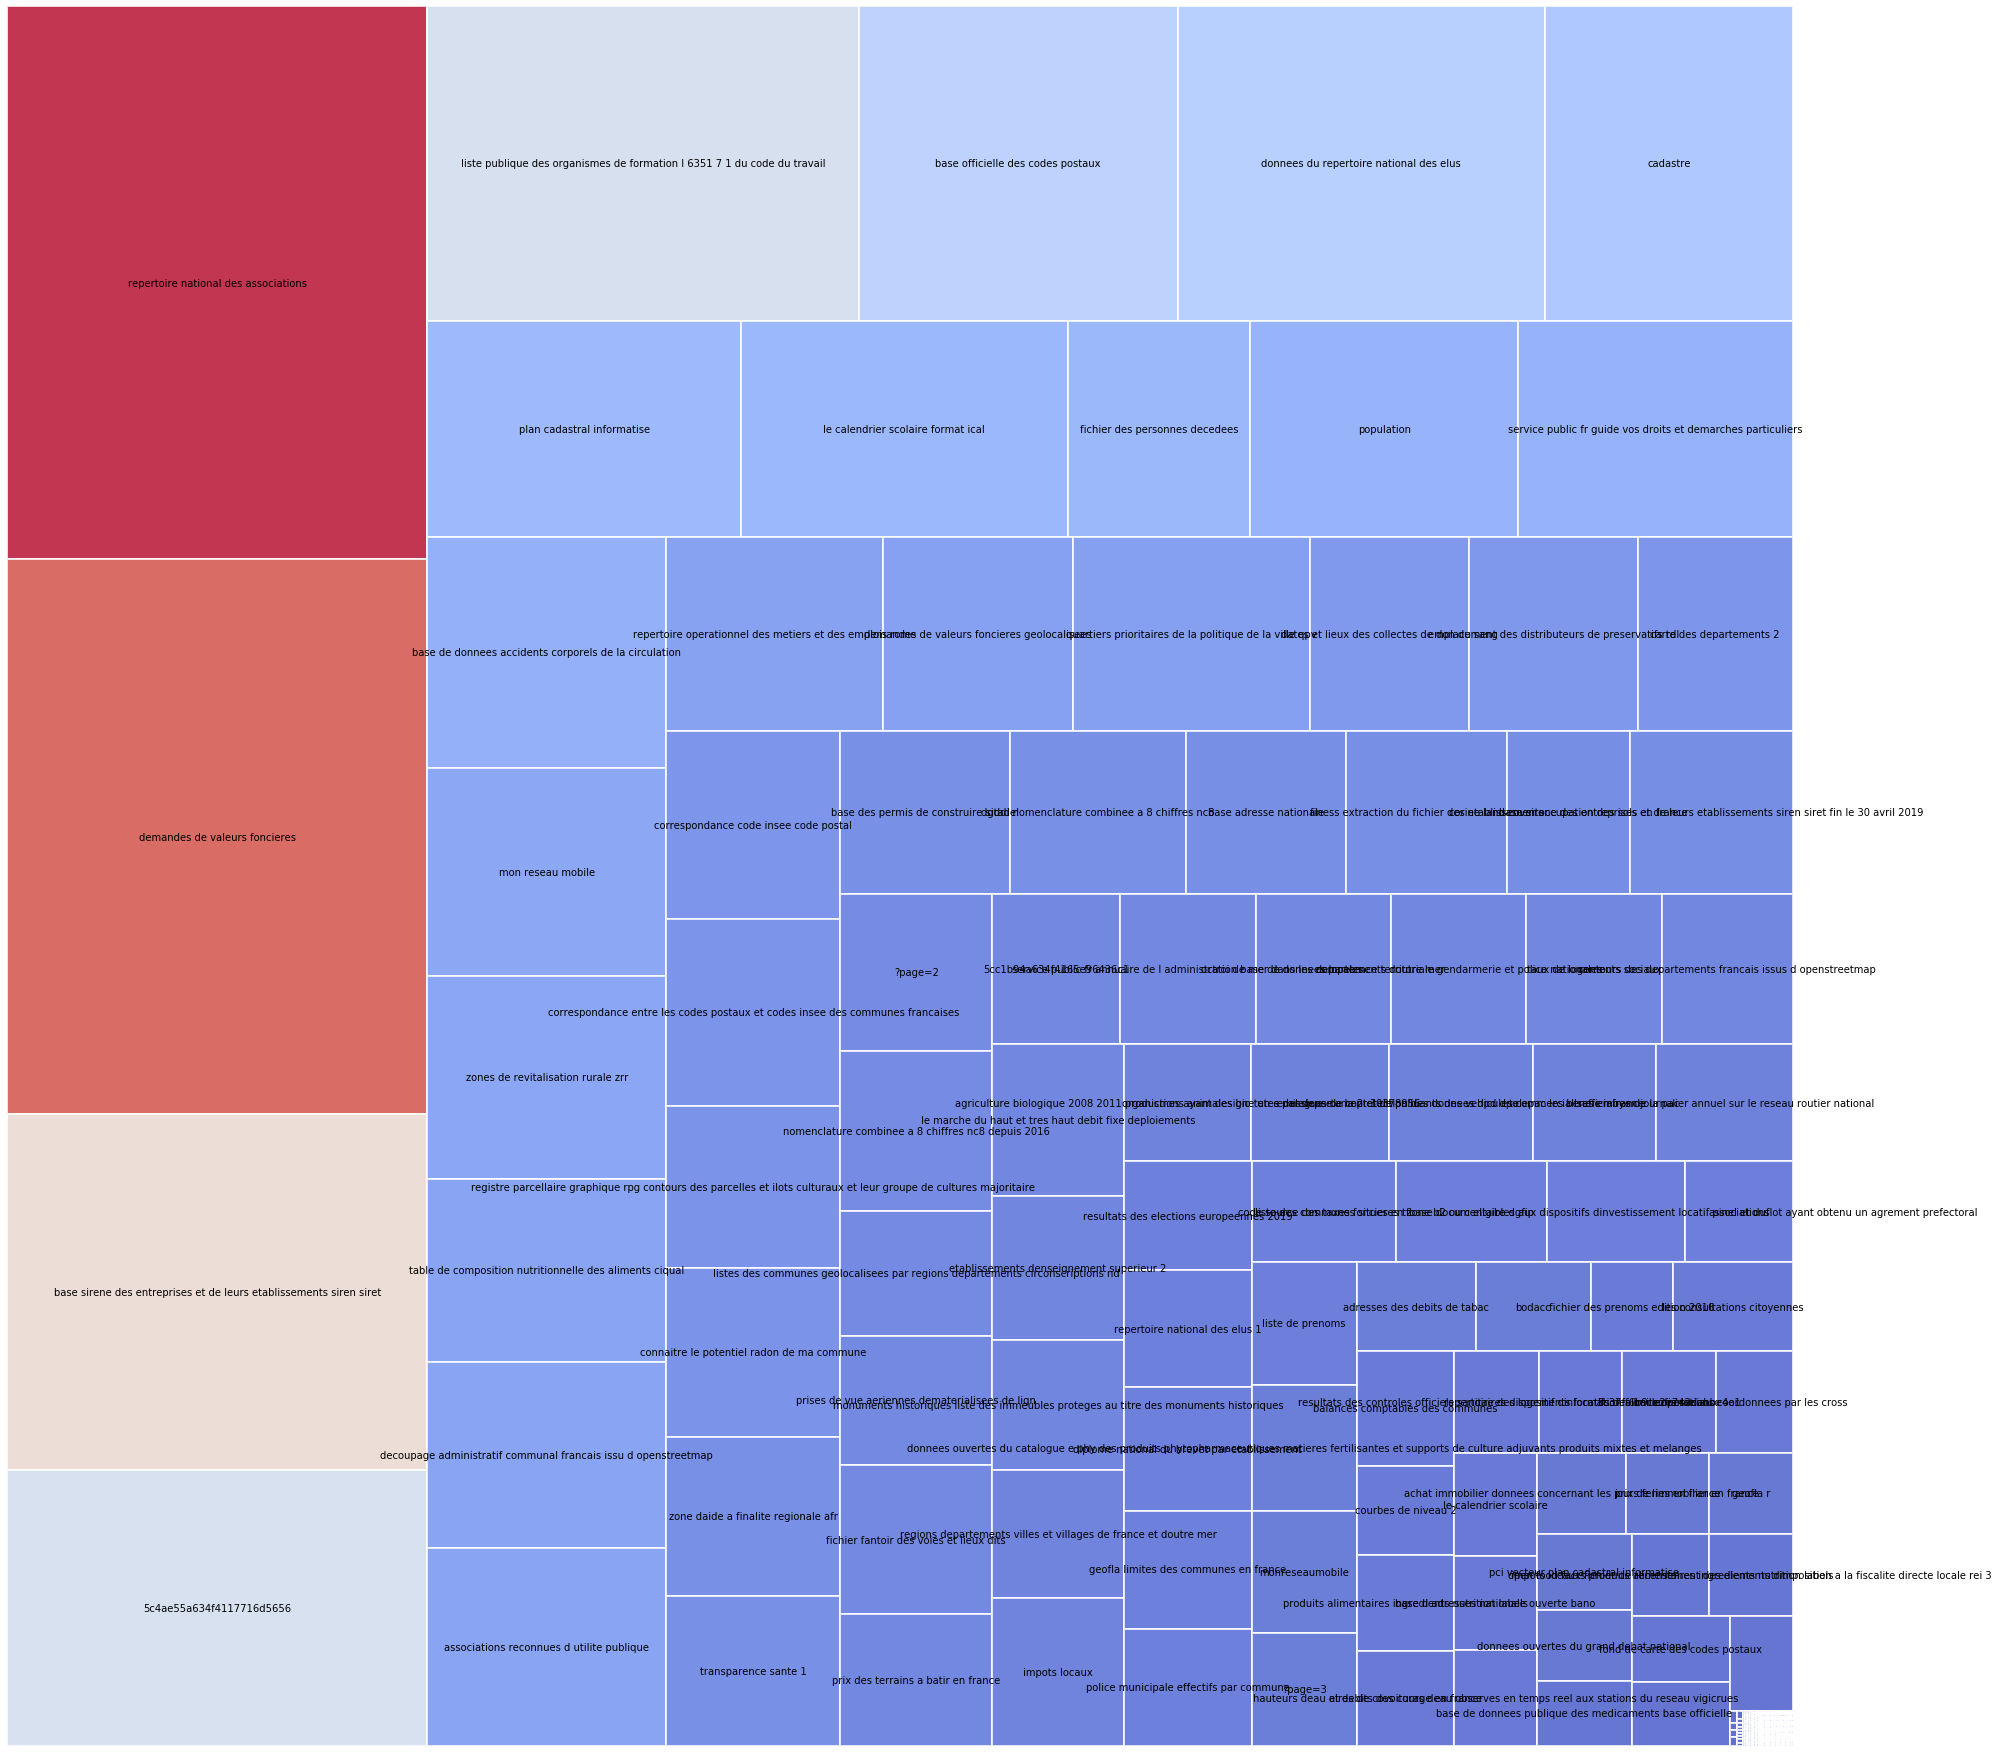

In [12]:
matplotlib.rcParams['figure.figsize'] = (32.0, 32.0)

# Get Axis and Figure
fig, ax = plt.subplots()

# Our Colormap
cmap = matplotlib.cm.coolwarm

# Min and Max Values
mini = min(df["nb_hits"])
maxi = max(df["nb_hits"])

# Finding Colors for each tile
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in df["nb_hits"]]

def label(row):
    if (row['nb_hits'] > 5000):
        
        l = row['url']
        l = l.replace('https://www.data.gouv.fr/fr/datasets/','')
        l = l.replace('http://www.data.gouv.fr/fr/datasets/','')
        l = l.replace('/','')
        l = l.replace('-',' ')
        
        return l
    else:
        return ''

# Plotting
squarify.plot(sizes=df['nb_visits'], color=colors, label=df.apply(label, axis=1), alpha=.8, linewidth=2, edgecolor="#ffffff")

# Removing Axis
plt.axis('off') 

# Invert Y-Axis
plt.gca().invert_yaxis()

# Title
#plt.title("Revenue from Star Wars Franchise Movies", fontsize=32)

# Title Positioning
# ttl = ax.title
# ttl.set_position([.5, 1.05])

# BG Color
fig.set_facecolor('#ffffff')

In [13]:
from vega import Vega

In [14]:
import seaborn as sns

In [15]:
import sklearn as sk

In [16]:
df['pctile'] = df['nb_hits'].rank(method="dense", pct=True)
df['pctile'] = df['nb_hits'].rank(pct=True)
df['pctile'] = df['nb_hits'].rank(method="min", pct=True)

def label(row):
    if (row['nb_hits'] > 5000):
        
        l = row['url']
        l = l.replace('https://www.data.gouv.fr/fr/datasets/','')
        l = l.replace('http://www.data.gouv.fr/fr/datasets/','')
        l = l.replace('/','')
        l = l.replace('-',' ')
        
        return l
    else:
        return ''

df['label'] = df.apply(label, axis=1)
    
df.to_json('temp.json', orient="records")

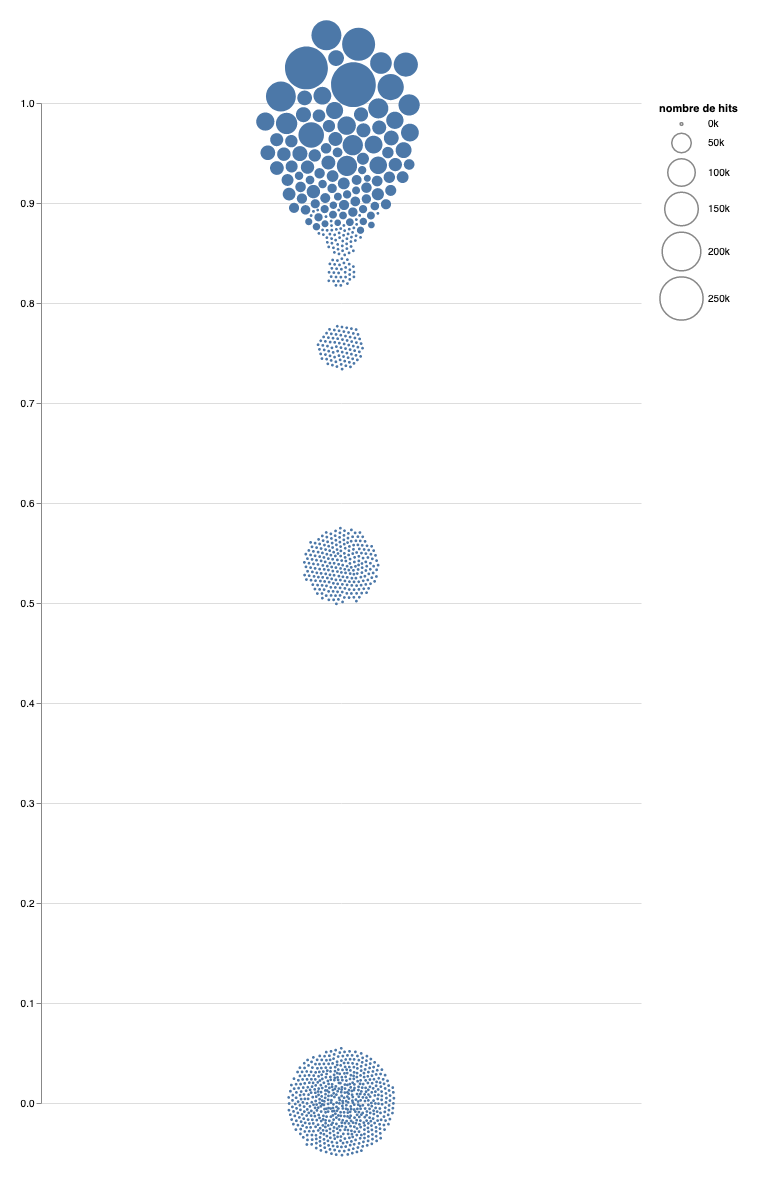

In [17]:
data = [
    {
        "name": "piwik",
        "url": "temp.json"
    }
]

scales = [
    {
        "name": "yscale",
        "domain": { "data": "piwik", "field": "pctile" },
        "nice": True,
        "range": "height"
    },
    {
        "name": "width_scale",
        "domain": { "data": "piwik", "field": "nb_hits", "type": "log" },
        "range": [8, 2000]
    }
]

marks = [
    {
        "name": "circles",
        'type' : 'symbol',
        'from': { "data": "piwik" },
        "encode": {
            "enter": {
                "xfocus": { "signal": "cx"},
                "yfocus": { "scale": "yscale", "field": "pctile"},
                "size":   { "scale": "width_scale", "field": "nb_hits"}
            }
        },
        "transform":[
            {
                "type": "force",
                "iteration": 300,
                "static": True,
                "forces": [
#                        {"force": "collide", "iterations": 1, "radius": {"expr": "scale('width_scale', datum.size)" } },
                    {"force": "collide", "iterations": 1, "radius": {"expr": "1 + sqrt(datum.size) / 2"} },
                    {"force": "y", "y": "yfocus", "strength": 2},
                    {"force": "x", "x": "xfocus", "strength": 2}
                ]
            }
        ]
    },
#         {
#             "type": "text",
#             "from": {"data": "circles"},
#             "encode": {
#                 "enter": {
#                       "align": {"value": "center"},
#                       "baseline": {"value": "middle"},
#                       "fontSize": {"value": 6},
#                       "text": {"field": "datum.label"}
#                 },
#                 "update": {
#                     "x": { "field": "x" },
#                     "y": { "field": "y" }
#                 }
#             }
#         },
]

Vega({
    "$schema": "https://vega.github.io/schema/vega/v4.json",
    "width": 600,
    "height": 1000,
    "padding": 20,
    "autosize": "pad",
    "background": "white",
    "data": data,
    "signals": [
      { "name": "cx", "update": "width/2" },
      { "name": "cy", "update": "height/2" } 
    ],
    "scales": scales,
    "axes":[
        { "orient": "left", "scale": "yscale", "grid": True}
    ],
    "legends":[
      {
          "size": "width_scale",
          "title": "nombre de hits",
          "format": "s",
          "tickCount": 4
      }  
    ],
    "marks": marks
})